In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [2]:
data = pd.read_csv('iris.txt', delimiter=" ", header = None)

In [3]:
data.astype(float)

,0,1,2,3
0,5.7,4.4,1.5,0.4
1,5.5,4.2,1.4,0.2
2,5.2,4.1,1.5,0.1
3,5.8,4.0,1.2,0.2
4,5.4,3.9,1.7,0.4
...,...,...,...,...
145,4.5,2.3,1.3,0.3
146,6.0,2.2,5.0,1.5
147,6.2,2.2,4.5,1.5
148,6.0,2.2,4.0,1.0


In [4]:
X_iris = data.values

In [5]:
scaler = StandardScaler()
iris_scaled = scaler.fit_transform(X_iris)

In [28]:
import umap

embedding = umap.UMAP(n_neighbors=12,
                      min_dist=0.3,
                      metric='correlation').fit_transform(iris_scaled)

In [42]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity = 5, random_state=42)
reduced_data = tsne.fit_transform(X_iris)
reduced_scaled = scaler.fit_transform(reduced_data)

In [11]:
import matplotlib.pyplot as plt

class KMeansCustom:
    def __init__(self, n_clusters=10, max_iters=300, tol=1e-4, init='k-means++', distance_metric='euclidean'):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.tol = tol
        self.init = init
        self.distance_metric = distance_metric

    def initialize_centroids(self, X):
        """Initialize centroids using K-Means++ or random selection"""
        np.random.seed(42)
        if self.init == 'k-means++':
            centroids = [X[np.random.randint(X.shape[0])]]
            for _ in range(1, self.n_clusters):
                dist_sq = np.min(self.compute_distances(X, np.array(centroids)) ** 2, axis=1)
                probs = dist_sq / dist_sq.sum()
                cumulative_probs = np.cumsum(probs)
                r = np.random.rand()
                index = np.searchsorted(cumulative_probs, r)
                centroids.append(X[index])
            return np.array(centroids)
        else:
            return X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

    def compute_distances(self, X, centroids):
        """Calculate distances between each point and each centroid based on the chosen metric"""
        if self.distance_metric == 'euclidean':
            return np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
        elif self.distance_metric == 'cosine':
            X_norm = X / np.linalg.norm(X, axis=1, keepdims=True)
            centroids_norm = centroids / np.linalg.norm(centroids, axis=1, keepdims=True)
            cosine_similarity = np.dot(X_norm, centroids_norm.T)
            return 1 - cosine_similarity  # Cosine distance = 1 - cosine similarity
        elif self.distance_metric == 'manhattan':
            return np.abs(X[:, np.newaxis] - centroids).sum(axis=2)
        else:
            raise ValueError("Unsupported distance metric. Choose 'euclidean', 'cosine', or 'manhattan'.")

    def update_centroids(self, X, labels):
        """Compute new centroids as the mean of the assigned points, handle empty clusters"""
        new_centroids = []
        for i in range(self.n_clusters):
            cluster_points = X[labels == i]
            if len(cluster_points) == 0:
                # Reinitialize empty cluster to a random point
                new_centroids.append(X[np.random.randint(X.shape[0])])
            else:
                new_centroids.append(cluster_points.mean(axis=0))
        return np.array(new_centroids)

    def fit(self, X):
        """Train the K-means algorithm"""
        self.centroids = self.initialize_centroids(X)
        for i in range(self.max_iters):
            old_centroids = self.centroids
            distances = self.compute_distances(X, self.centroids)
            self.labels = np.argmin(distances, axis=1)
            self.centroids = self.update_centroids(X, self.labels)
            if np.all(np.abs(self.centroids - old_centroids) < self.tol):
                break
        return self

    def predict(self, X):
        """Predict the closest cluster each sample in X belongs to"""
        distances = self.compute_distances(X, self.centroids)
        return np.argmin(distances, axis=1)

    def calculate_sse(self, X):
        """Calculate sum of squared errors (SSE) for current clustering"""
        distances = self.compute_distances(X, self.centroids)
        min_distances = np.min(distances, axis=1)
        sse = np.sum(min_distances ** 2)
        return sse

# Using the Elbow Method to find the optimal number of clusters
def plot_elbow_method(X, max_k=10, distance_metric='euclidean'):
    sse_values = []
    k_values = range(1, max_k + 1)
    
    for k in k_values:
        kmeans = KMeansCustom(n_clusters=k, max_iters=200, tol=1e-4, distance_metric=distance_metric)
        kmeans.fit(X)
        sse = kmeans.calculate_sse(X)
        sse_values.append(sse)
        print(f'SSE for {k} clusters: {sse}')
    
    # Plotting the SSE values for each k
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, sse_values, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Errors (SSE)')
    plt.title('Elbow Method for Optimal k')
    plt.show()
    
    # Calculate the elbow point
    sse_diffs = np.diff(sse_values)
    elbow_k = np.argmin(np.diff(sse_diffs)) + 1  # Adding 1: 1 for np.diff
    print(f"Optimal number of clusters based on elbow method: {elbow_k}")


SSE for 1 clusters: 300.0
SSE for 2 clusters: 148.44381713867188
SSE for 3 clusters: 137.08934020996094
SSE for 4 clusters: 37.87620544433594
SSE for 5 clusters: 17.698753356933594
SSE for 6 clusters: 14.122299194335938
SSE for 7 clusters: 12.254451751708984
SSE for 8 clusters: 7.075887680053711
SSE for 9 clusters: 6.688939571380615
SSE for 10 clusters: 6.103724479675293


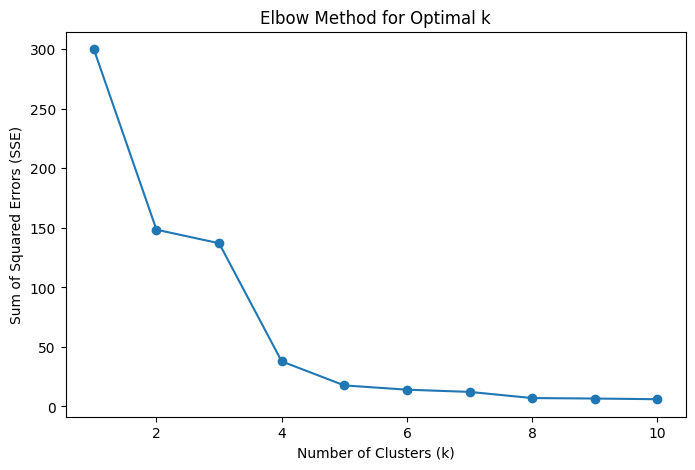

Optimal number of clusters based on elbow method: 2


In [40]:
plot_elbow_method(reduced_scaled, max_k=10, distance_metric='euclidean')

SSE for 1 clusters: 1989.2522177168862
SSE for 2 clusters: 651.2432999746388
SSE for 3 clusters: 365.13457918570714
SSE for 4 clusters: 292.7413893157514
SSE for 5 clusters: 267.32475194940946
SSE for 6 clusters: 217.460388551141
SSE for 7 clusters: 190.5779455695406
SSE for 8 clusters: 160.12959931542798
SSE for 9 clusters: 151.9229084383757
SSE for 10 clusters: 137.13585785281452


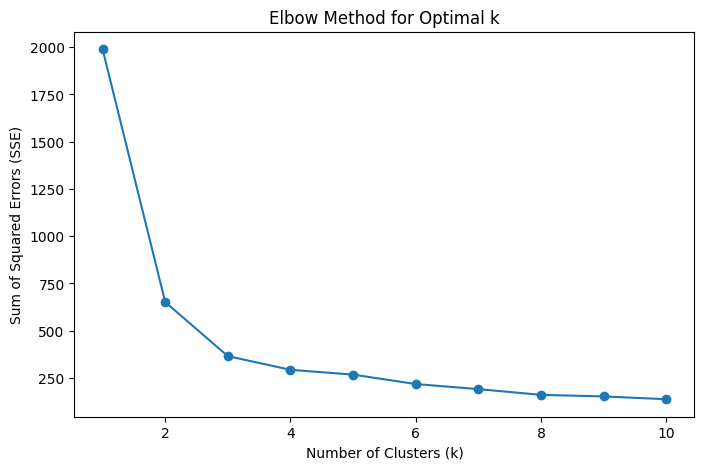

Optimal number of clusters based on elbow method: 4


In [14]:
plot_elbow_method(iris_scaled, max_k=10, distance_metric='manhattan')

SSE for 1 clusters: 101170.1875
SSE for 2 clusters: 13339.9560546875
SSE for 3 clusters: 11682.6240234375
SSE for 4 clusters: 4448.27734375
SSE for 5 clusters: 2584.9326171875
SSE for 6 clusters: 2128.51708984375
SSE for 7 clusters: 1719.900390625
SSE for 8 clusters: 1229.27490234375
SSE for 9 clusters: 1010.4357299804688
SSE for 10 clusters: 963.2229614257812


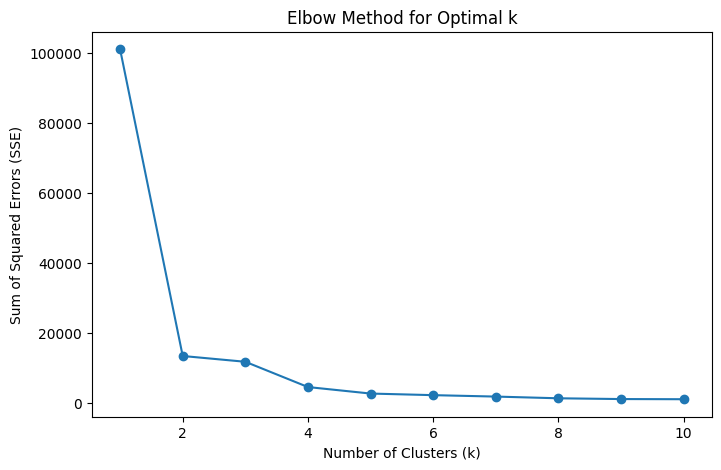

Optimal number of clusters based on elbow method: 2


In [24]:
plot_elbow_method(reduced_data, max_k=10, distance_metric='euclidean')

SSE for 1 clusters: 142365.03125
SSE for 2 clusters: 18802.376953125
SSE for 3 clusters: 16594.06640625
SSE for 4 clusters: 7027.70068359375
SSE for 5 clusters: 3955.697998046875
SSE for 6 clusters: 3456.07861328125
SSE for 7 clusters: 2895.56494140625
SSE for 8 clusters: 2437.734375
SSE for 9 clusters: 2372.6630859375
SSE for 10 clusters: 2298.19921875


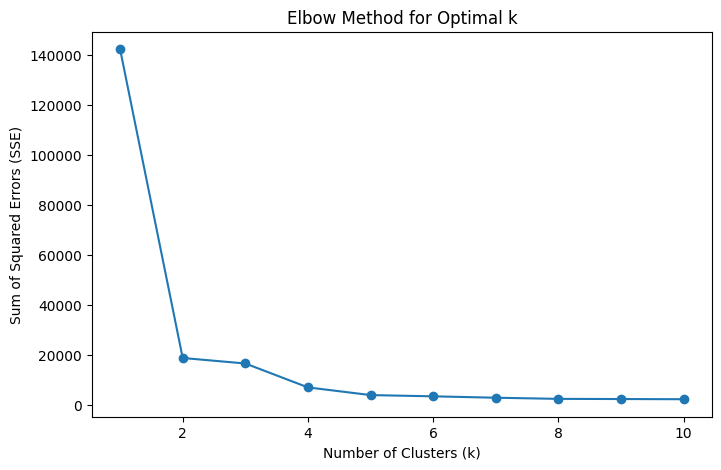

Optimal number of clusters based on elbow method: 2


In [25]:
plot_elbow_method(reduced_data, max_k=10, distance_metric='manhattan')

In [41]:
kmeans = KMeansCustom(n_clusters=3, max_iters=300, tol=1e-3, init='k-means++', distance_metric='euclidean')
kmeans.fit(reduced_scaled)
labels = kmeans.predict(reduced_scaled)

# Save the clustering output to format.txt file
output_file = 'format.txt'
submission = pd.DataFrame(labels + 1, columns=['ClusterID'])
submission.to_csv(output_file, index=False, header=False)

print(f'Clustering output saved to {output_file}')


Clustering output saved to format.txt


In [2]:
data_star = pd.read_csv('StarLightCurves.csv', header = None)

In [64]:
from sklearn.manifold import TSNE
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler



def preprocess_data(data):
    # Step 1: Smooth the data
    #data_smoothed = np.array([savgol_filter(curve, window_length=10, polyorder=1, deriv=1) for curve in data])
    # tsne = TSNE(n_components=2, perplexity = 15, random_state=42)
    # data = tsne.fit_transform(data)
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    return data


In [57]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

def autoencoder_embedding(data, encoding_dim=25):
    # Define encoder-decoder architecture
    input_layer = Input(shape=(data.shape[1],))
    encoded = Dense(encoding_dim, activation='sigmoid')(input_layer)
    decoded = Dense(data.shape[1], activation='relu')(encoded)

    # Compile autoencoder
    autoencoder = Model(input_layer, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    # Train autoencoder
    autoencoder.fit(data, data, epochs=75, batch_size=100, shuffle=True, verbose=0)

    # Extract embeddings
    embeddings = encoder.predict(data)
    return embeddings


In [80]:
em = autoencoder_embedding(data_star.values, encoding_dim=25)

258/258 [==============================] - 1s 3ms/step


In [65]:
processed_data = preprocess_data(data_star.values)

SSE for 1 clusters: 13951.5888671875
SSE for 2 clusters: 9110.431640625
SSE for 3 clusters: 8315.1025390625
SSE for 4 clusters: 7933.87158203125
SSE for 5 clusters: 7690.095703125
SSE for 6 clusters: 7588.48779296875
SSE for 7 clusters: 4891.4228515625
SSE for 8 clusters: 4100.38623046875
SSE for 9 clusters: 4014.5712890625
SSE for 10 clusters: 3723.332275390625


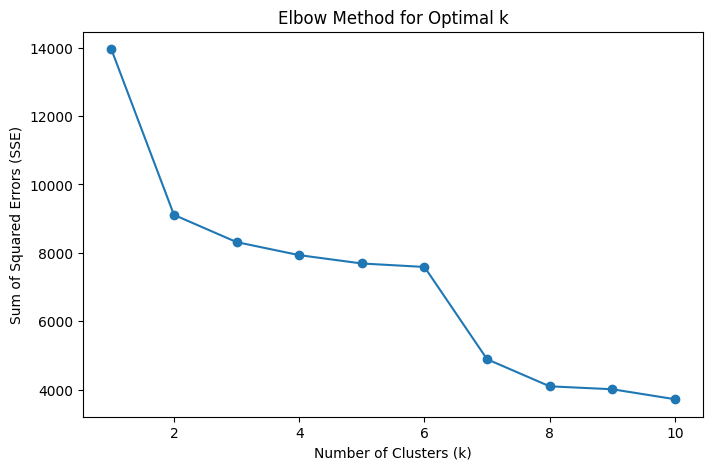

Optimal number of clusters based on elbow method: 5


In [81]:
plot_elbow_method(em, 10, distance_metric = 'euclidean')

In [66]:
plot_elbow_method(processed_data, 10, distance_metric = 'euclidean')

SSE for 1 clusters: 8433664.0
SSE for 2 clusters: 5042377.31874735
SSE for 3 clusters: 3104726.4230247256


KeyboardInterrupt: 

In [79]:
kmeans = KMeansCustom(n_clusters=3, max_iters=300, tol=1e-3, init='k-means++', distance_metric='euclidean')
kmeans.fit(em)
labels = kmeans.predict(em)

# Save the clustering output to format.txt file
output_file = 'format.txt'
submission = pd.DataFrame(labels + 1, columns=['ClusterID'])
submission.to_csv(output_file, index=False, header=False)

print(f'Clustering output saved to {output_file}')


Clustering output saved to format.txt
